# Sample AFHQ Cat <-> Wild

In [1]:
import torch as th
import torchvision.utils as tu
from torch.utils.data import Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from utils import EMAHelper, load_state_dict, euler_discretization, draw_square
from models.transformer import OperatorTransformer

In [2]:
ckpt_path = './checkpoint/afhq_catwild_400000.npz'

In [3]:
th.manual_seed(42)
np.random.seed(42)

device = th.device("cuda:0")
checkpoint = th.load(ckpt_path, map_location=device)

In [4]:
def init_nn():
    return OperatorTransformer(
        in_channel = 2,
        out_channel = 3,
        latent_dim = 512,
        pos_dim = 512,
        num_heads = 4,
        depth_enc = 6,
        depth_dec = 2,
        scale = 1,
        self_per_cross_attn = 2,
        height=64
    )
def load_model(checkpoint, device):
    fwd_nn = init_nn().to(device)
    bwd_nn = init_nn().to(device)

    ema_decay=0.999
    fwd_ema = EMAHelper(fwd_nn, ema_decay, device)
    bwd_ema = EMAHelper(bwd_nn, ema_decay, device)

    saves = [bwd_nn, bwd_ema, fwd_nn, fwd_ema]
    ckpt_keys = ['bwd_nn', 'bwd_ema', 'fwd_nn', 'fwd_ema']

    load_state_dict(checkpoint, saves, ckpt_keys)
    fwd_sample_nn = fwd_ema.ema_copy()
    bwd_sample_nn = bwd_ema.ema_copy()

    return fwd_sample_nn, bwd_sample_nn

fwd_sample_nn, bwd_sample_nn = load_model(checkpoint, device)
print('Model loaded')

Model loaded


In [5]:
discretization_steps = 100
dt = 1.0 / discretization_steps
sigma = 1.0

sample_type = "cat2wild"
# sample_type = "cat2dog"

direction = "fwd" # cat -> wild
# direction = "bwd" # wild -> cat
    
if direction == "fwd":
    source = "cat"
    target = "wild" if sample_type == "cat2wild" else "dog"
    model = fwd_sample_nn.eval()
else:
    source = "wild" if sample_type == "cat2wild" else "dog"
    target = "cat" 
    model = bwd_sample_nn.eval()

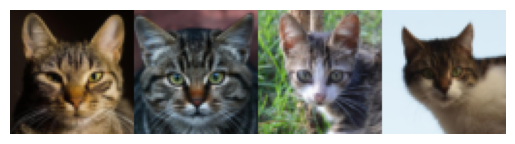

In [6]:
DATA_DIR = './data/afhq'
data_split = "train"
dataset = datasets.ImageFolder(root=f'{DATA_DIR}/{data_split}')
idx_src = np.array([i for i in range(len(dataset)) if dataset.imgs[i][1] == dataset.class_to_idx[f'{source}']])
data_src = Subset(dataset, idx_src)

def init_transform(res):
    return transforms.Compose([
            transforms.Resize([res , res]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
transform = init_transform(64)

if source == 'cat':
    if sample_type == "cat2wild":
        sample_ids = [2836, 3125, 4970, 5090] # cat -> wild
    else:
        sample_ids = [1436, 1753, 1162, 2843] # cat -> dog
else:
    if sample_type == "cat2wild":
        sample_ids = [5, 3777, 1137, 2502] # wild -> cat
    else:
        sample_ids = [66, 67, 1072, 1375] # dog -> cat

images = th.stack([transform(data_src[i][0]) for i in sample_ids], dim=0)

def show_image(images, ncol=4, padding=0):
    images = th.clip((images + 1.0) / 2.0, 0.0, 1.0)
    img_size = images.shape[-1]
    tv_images = tu.make_grid(images, nrow=ncol, padding=padding, pad_value=1.0)
    plt.figure(dpi=int(100*(img_size/64)))
    plt.imshow(tv_images.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

show_image(images, ncol=4)

Sampling resolution: 64x64
Sampling resolution: 128x128


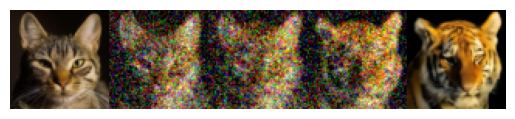

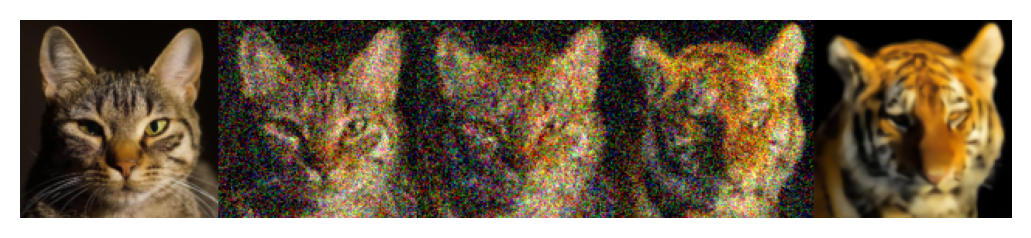

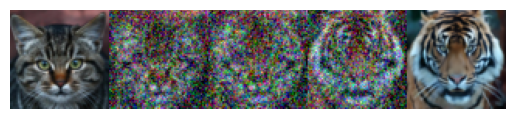

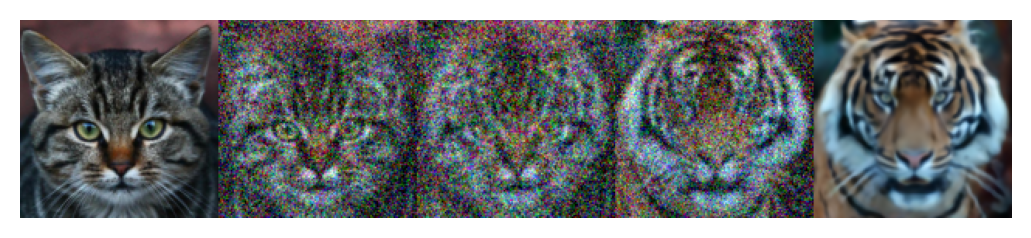

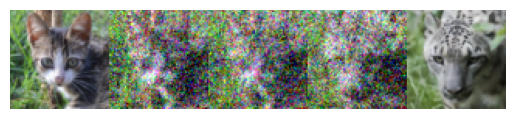

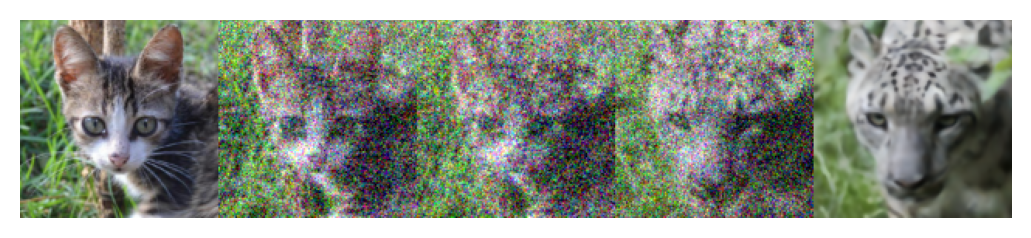

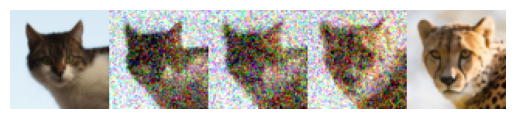

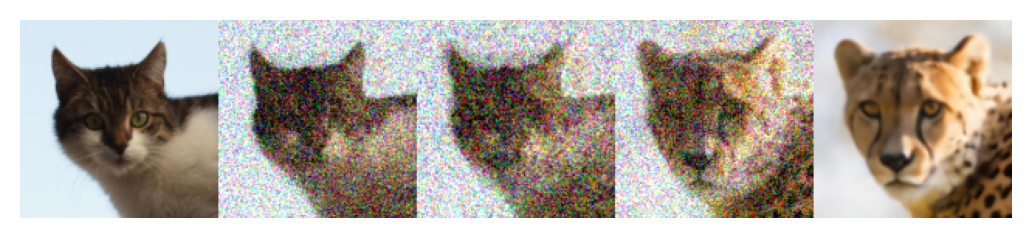

In [7]:
resolutions = [64, 128]
batch_sizes = [4, 2]

results = []
for res in resolutions:
    print(f"Sampling resolution: {res}x{res}")
    transform = init_transform(res)
    batch_dim = batch_sizes[resolutions.index(res)]
    batch_dim = max(1, min(batch_dim, len(sample_ids)))

    xts_list = []    
    for b_i in range(int(np.ceil(len(sample_ids) / batch_dim))):
        # Load the images and preprocess
        input_ids = sample_ids[b_i * batch_dim: (b_i + 1) * batch_dim]
        images = th.stack([transform(data_src[i][0]) for i in input_ids], dim=0).to(device)

        # Initialize the path
        s_path = th.zeros(size=(discretization_steps + 1,) + (batch_dim, 3, res, res), device=device)
        p_path = th.zeros(size=(discretization_steps,) + (batch_dim, 3, res, res), device=device)
        s_path[0] = images

        # Sampling images
        with th.no_grad():
            euler_discretization(s_path, p_path, model, sigma, device)
            
        xts_list.append(s_path.cpu())
    xts = th.cat(xts_list, dim=1)
    results.append(xts)

# Display sampled images
for i in range(len(sample_ids)):
    for j in range(len(resolutions)):
        summary_index = [0, 20, 40, 80, -1]
        show_image(results[j][summary_index, i], ncol=5)

# Generate GIF samples

In [35]:
resolutions = [64, 128]
batch_sizes = [4, 2]

data_src = datasets.ImageFolder(root=f'{DATA_DIR}/train')
val_data_src = datasets.ImageFolder(root=f'{DATA_DIR}/val')

results = []
for res in resolutions:
    print(f"Sampling resolution: {res}x{res}")
    transform = init_transform(res)
    batch_dim = batch_sizes[resolutions.index(res)]

    if res == 64:
        if sample_type == "cat2wild":
            if source == 'cat':
                sample_ids = ['train_30','train_2119','train_670','val_128',
                            'val_180','train_372','train_897','train_1091',
                            'train_1215','train_1840','train_2836','train_3125',
                            'train_3248','train_4349','train_4970','train_5090',]
            else:
                sample_ids = ['train_14133','train_11450','val_1193','train_11191',
                            'train_12978','train_13400','train_14122','train_12392',
                            'train_13080','train_11717','train_9897','train_13669',
                            'train_12966','train_12973','train_11029','train_12394',]
        else:
            if source == 'cat':
                sample_ids = ['train_2047','val_230','train_3564','train_2676',
                              'train_4765','train_1066','train_2063','train_1053',
                              'train_4013','val_437','train_1436','train_1753',
                              'train_3358','train_1619','train_1162','train_2843',]
            else:
                sample_ids = ['train_5176', 'train_5625', 'train_5632', 'train_5451',
                              'train_7238', 'train_6858', 'train_6632', 'train_5281',
                              'train_6849', 'train_6902', 'train_5219', 'train_5220',
                              'train_5258', 'train_6219', 'train_6225', 'train_6528',]
    elif res == 128:
        if sample_type == "cat2wild":
            if source == 'cat':
                sample_ids = ['train_2836','train_3125',
                            'train_4970','train_5090',]
            else:
                sample_ids = ['train_9897','train_13669',
                            'train_11029','train_12394',]
        else:
            if source == 'cat':
                sample_ids = ['train_1436','train_1753',
                              'train_1162','train_2843',]
            else:
                sample_ids = ['train_5219', 'train_5220',
                              'train_6225', 'train_6528',]
                              
    batch_dim = max(1, min(batch_dim, len(sample_ids)))
    xts_list = []    
    for b_i in range(int(np.ceil(len(sample_ids) / batch_dim))):        
        # Load the images and preprocess
        input_ids = sample_ids[b_i * batch_dim: (b_i + 1) * batch_dim]
        images = []
        for input_id in input_ids:
            split, idx = input_id.split('_')
            if split == 'train':
                images.append(transform(data_src[int(idx)][0]))
            else:
                images.append(transform(val_data_src[int(idx)][0]))
        images = th.stack(images, dim=0).to(device)

        # Initialize the path
        s_path = th.zeros(size=(discretization_steps + 1,) + (batch_dim, 3, res, res), device=device)
        p_path = th.zeros(size=(discretization_steps,) + (batch_dim, 3, res, res), device=device)
        s_path[0] = images

        # Sampling images
        with th.no_grad():
            euler_discretization(s_path, p_path, model, sigma, device)

        xts_list.append(s_path.cpu())
    xts = th.cat(xts_list, dim=1)
    results.append(xts)

Sampling resolution: 64x64
Sampling resolution: 128x128


In [36]:
import os
import imageio

os.makedirs('./assets', exist_ok=True)
for res_i in range(len(resolutions)):
    xts = results[res_i]
    res = resolutions[res_i]
    if res == 64: ncols = min(4, xts.size(1))
    elif res == 128: ncols = min(2, xts.size(1))

    images = []
    for t_i in range(xts.size(0)):
        imgs = xts[t_i]
        imgs = th.clip((imgs + 1.0) / 2.0, 0.0, 1.0)
        tu_imgs = tu.make_grid(imgs, nrow=ncols, padding=1, pad_value=1).permute(1, 2, 0)

        if res == 64:
            tu_imgs = draw_square(tu_imgs, (res+1)*(ncols//2), (res+1)*(ncols//2), (res+1)*(ncols)+1, (res+1)*(ncols)+1, thick=4, color='r')
        elif res == 128:
            tu_imgs = draw_square(tu_imgs, 0, 0, (res+1)*(ncols)+1, (res+1)*(ncols)+1, thick=8, color='r')

        tu_imgs = (tu_imgs.numpy() * 255).astype(np.uint8)
        images.append(tu_imgs)

    imageio.mimsave(f'./assets/{source}2{target}_{res}.gif', images, duration=0.1, loop=0)